In [2]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

path = '/content/drive/MyDrive/hostel_library_synthetic.csv'
df = pd.read_csv(path)
df.head()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler



Mounted at /content/drive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hostel_id        2920 non-null   object 
 1   date             2920 non-null   object 
 2   weekday          2920 non-null   int64  
 3   borrowed_books   2920 non-null   int64  
 4   avg_study_hours  2920 non-null   float64
 5   exam_flag        2920 non-null   int64  
 6   festival_flag    2920 non-null   int64  
 7   hostel_capacity  2920 non-null   int64  
 8   threshold        2920 non-null   float64
 9   high_demand      2920 non-null   int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 228.3+ KB


In [4]:
df.head()

,hostel_id,date,weekday,borrowed_books,avg_study_hours,exam_flag,festival_flag,hostel_capacity,threshold,high_demand
0,H01,2024-01-01,1,9,3.60,0,0,151,16.2,0
1,H01,2024-01-02,1,12,4.00,0,0,151,16.2,0
2,H01,2024-01-03,1,11,3.76,0,0,151,16.2,0
3,H01,2024-01-04,1,12,3.83,0,0,151,16.2,0
4,H01,2024-01-05,1,15,3.76,0,0,151,16.2,0


<Axes: xlabel='hostel_id'>

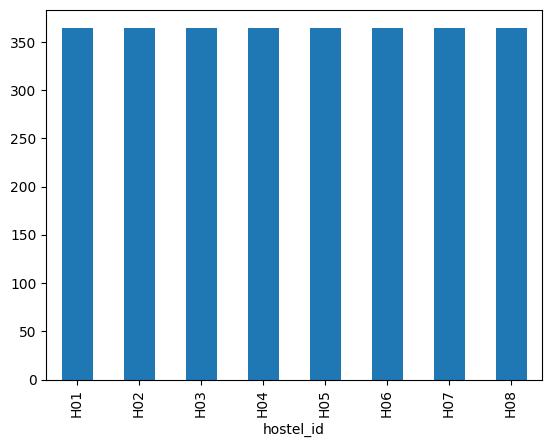

In [5]:
df['hostel_id'].value_counts().plot(kind='bar')

In [6]:
train_data={}
test_data={}


#will try different test train splits like 0.75,0.8,0.85,0.9
for hostel,sub_df in df.groupby('hostel_id'):
  cutoff=int(0.8*len(sub_df))
  train_data[hostel]=sub_df.iloc[:cutoff]
  test_data[hostel]=sub_df.iloc[cutoff:]

In [7]:
df['hostel_id'].value_counts()

,count
hostel_id,
H01,365
H02,365
H03,365
H04,365
H05,365
H06,365
H07,365
H08,365


In [8]:
features = ['weekday', 'borrowed_books', 'avg_study_hours',
            'exam_flag', 'festival_flag', 'hostel_capacity']
target = 'high_demand'


In [9]:
scaler=StandardScaler()
scaler.fit(df[features])

StandardScaler()

In [10]:
for h in train_data:
    train_data[h].loc[:, features] = scaler.transform(train_data[h][features])
    test_data[h].loc[:, features] = scaler.transform(test_data[h][features])


/tmp/ipython-input-857932472.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.63124277  0.63124277  0.63124277  0.63124277  0.63124277 -1.58417656
 -1.58417656  0.63124277  0.63124277  0.63124277  0.63124277  0.63124277
 -1.58417656 -1.58417656  0.63124277  0.63124277  0.63124277  0.63124277
  0.63124277 -1.58417656 -1.58417656  0.63124277  0.63124277  0.63124277
  0.63124277  0.63124277 -1.58417656 -1.58417656  0.63124277  0.63124277
  0.63124277  0.63124277  0.63124277 -1.58417656 -1.58417656  0.63124277
  0.63124277  0.63124277  0.63124277  0.63124277 -1.58417656 -1.58417656
  0.63124277  0.63124277  0.63124277  0.63124277  0.63124277 -1.58417656
 -1.58417656  0.63124277  0.63124277  0.63124277  0.63124277  0.63124277
 -1.58417656 -1.58417656  0.63124277  0.63124277  0.63124277  0.63124277
  0.63124277 -1.58417656 -1.58417656  0.63124277  0.63124277  0.63124277
  0.63124277  0.63124277 -1.58417656 -1.5841

In [11]:
local_models={}

for i in train_data:
  X=train_data[i][features]
  y=train_data[i][target]
  model=LogisticRegression(max_iter=200)
  model.fit(X,y)
  local_models[i]=model




In [12]:
coefs = []
intercepts = []
sizes = []

for h, model in local_models.items():
    coefs.append(model.coef_)
    intercepts.append(model.intercept_)
    sizes.append(len(train_data[h]))

total = sum(sizes)

#fedavg basically
avg_coef = sum(coefs[i] * (sizes[i] / total) for i in range(len(coefs)))
avg_intercept = sum(intercepts[i] * (sizes[i] / total) for i in range(len(intercepts)))


In [20]:
# Ensure proper numpy shapes before dot-products
avg_coef = np.array(avg_coef).reshape(1, -1)        # shape (1, n_features)
avg_intercept = np.array(avg_intercept).reshape(-1) # shape (1,)

X_test=pd.concat([test_data[h][features] for h in test_data])
Y_test=pd.concat([test_data[h][target] for h in test_data])

X_test_arr=X_test.values

logits = X_test.values.dot(avg_coef.T).ravel() + avg_intercept

preds=(logits>0).astype(int)

fedacc=accuracy_score(y_test, preds)

print(f"FedAvg Global Model Test Accuracy: {fedacc:.4f}")

FedAvg Global Model Test Accuracy: 0.9041


In [21]:
X_train_all = pd.concat([train_data[h][features] for h in train_data], ignore_index=True)
y_train_all = pd.concat([train_data[h][target] for h in train_data], ignore_index=True)

central_model = LogisticRegression(max_iter=500)
central_model.fit(X_train_all, y_train_all)

central_preds = central_model.predict(X_test_arr)
central_acc = accuracy_score(y_test, central_preds)
print(f"Centralized Model Test Accuracy: {central_acc:.4f}")

Centralized Model Test Accuracy: 0.9538


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [22]:
per_hostel = []
for h in test_data:
    Xt = test_data[h][features].values
    yt = test_data[h][target].values
    # FedAvg on hostel
    logits_h = Xt.dot(avg_coef.T).ravel() + avg_intercept
    preds_h = (logits_h > 0).astype(int)
    fed_acc_h = accuracy_score(yt, preds_h)
    # Centralized on hostel
    central_pred_h = central_model.predict(Xt)
    cent_acc_h = accuracy_score(yt, central_pred_h)
    per_hostel.append({'hostel': h, 'fedacc': fed_acc_h, 'centralacc': cent_acc_h, 'n_test': len(yt)})

per_hostel_df = pd.DataFrame(per_hostel)
print("\nPer-hostel accuracy (FedAvg vs Centralized):")
print(per_hostel_df)


Per-hostel accuracy (FedAvg vs Centralized):
  hostel    fedacc  centralacc  n_test
0    H01  0.931507    1.000000      73
1    H02  0.739726    0.849315      73
2    H03  0.986301    0.986301      73
3    H04  0.958904    0.958904      73
4    H05  0.958904    0.945205      73
5    H06  0.904110    1.000000      73
6    H07  0.958904    0.917808      73
7    H08  0.794521    0.972603      73


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist

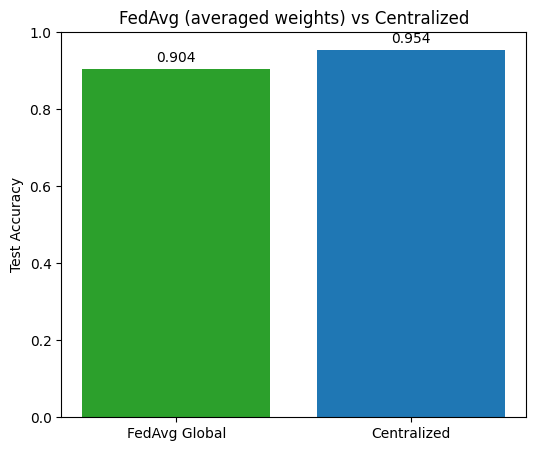

In [23]:
plt.figure(figsize=(6,5))
bars = plt.bar(['FedAvg Global', 'Centralized'], [fedacc, central_acc], color=['#2ca02c', '#1f77b4'])
plt.ylim(0,1)
plt.ylabel('Test Accuracy')
plt.title('FedAvg (averaged weights) vs Centralized')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{bar.get_height():.3f}",
             ha='center', va='bottom')
plt.show()

